In [842]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,FunctionTransformer,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score,f1_score
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
%matplotlib inline

In [559]:
data = pd.read_csv("census-income.csv").rename(columns={'Unnamed: 14':'label'})

In [560]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [561]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

In [562]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [563]:
data.label.replace({'<=50K':0,'>50K':1},inplace=True)

In [564]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [565]:
data.corr(numeric_only=True)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
label,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


In [566]:
data.label.value_counts()

label
0    24720
1     7841
Name: count, dtype: int64

In [569]:
data.shape

(30162, 12)

In [567]:
data.workclass.replace({'?':np.nan},inplace=True)
data.occupation.replace({'?':np.nan},inplace=True)
data['native-country'].replace({'?':np.nan},inplace=True)

data.dropna(inplace=True)

In [11]:
data.workclass.replace({'?':'other'},inplace=True)
data.occupation.replace({'?':'other'},inplace=True)
data['native-country'].replace({'?':'other'},inplace=True)

In [568]:
data.drop(['education','fnlwgt','native-country'],axis=1,inplace=True)

## EDA

In [10]:
#print(data.education.value_counts(),data['education-num'].value_counts())

In [11]:
for i in data.columns:
    print(data[i].value_counts())

age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
fnlwgt
164190    13
203488    13
123011    13
148995    12
121124    12
          ..
232784     1
325573     1
140176     1
318264     1
257302     1
Name: count, Length: 21648, dtype: int64
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

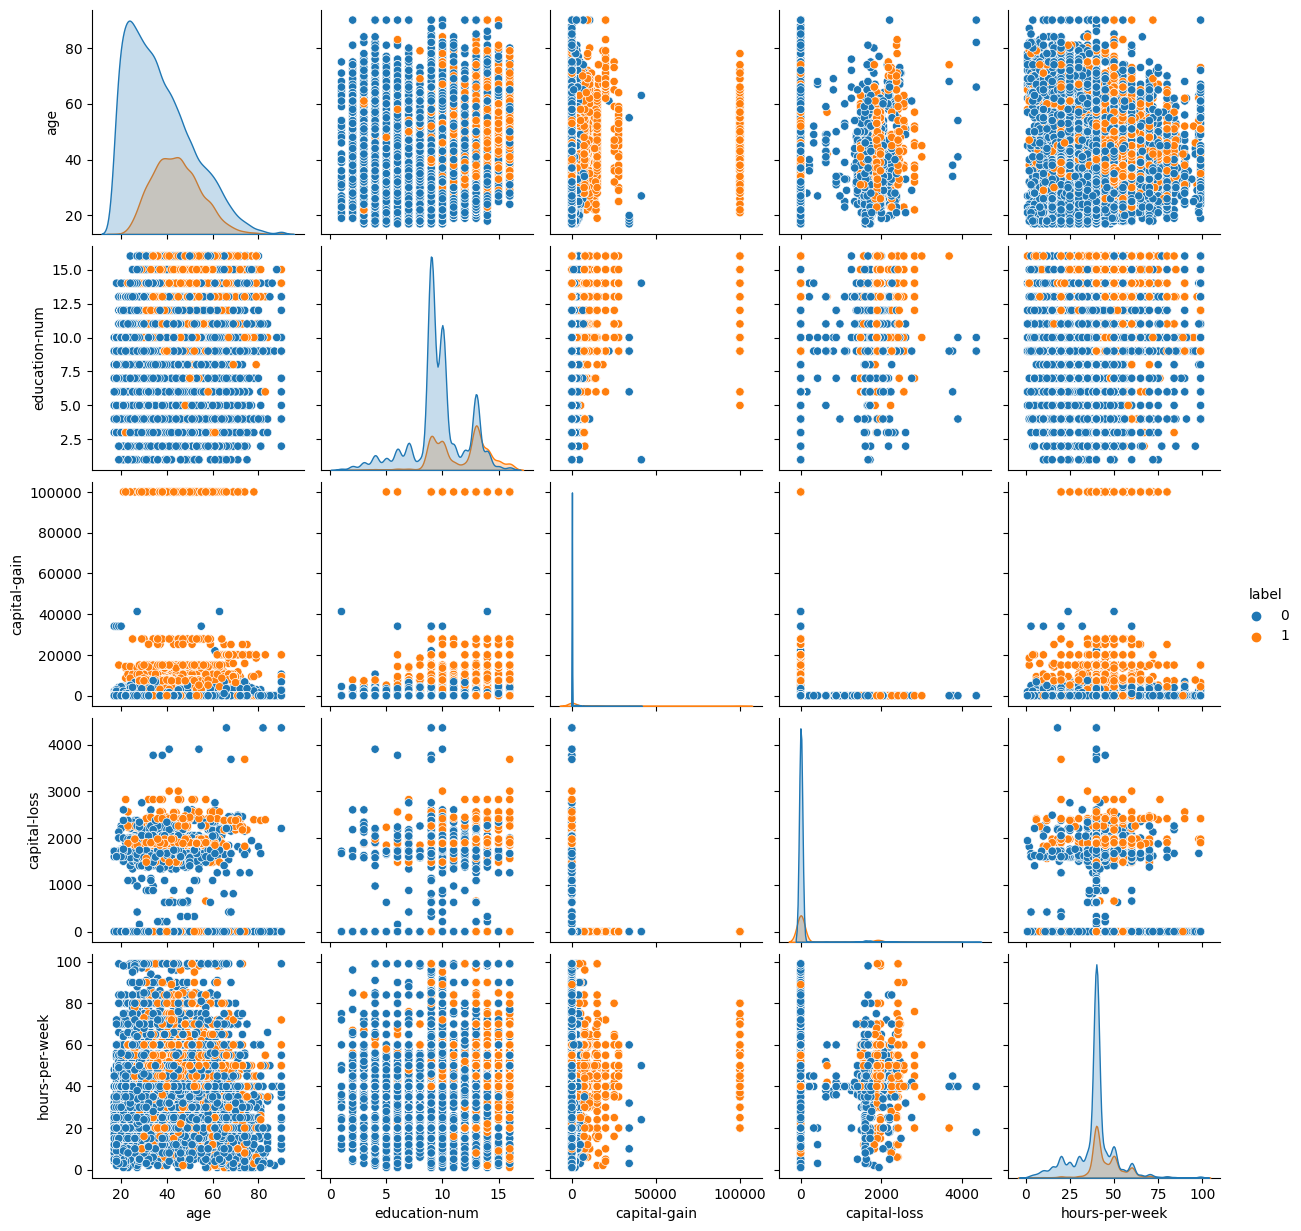

In [25]:
sns.pairplot(data,hue='label')

In [17]:
#(data['native-country'].value_counts()/data['native-country'].value_counts().sum())*100

In [51]:
#data['native-country'].value_counts().sum()

In [71]:
data.groupby(['native-country','label'])['label'].count()/data.groupby(['native-country'])['label'].count()*100

native-country  label
Cambodia        0        63.157895
                1        36.842105
Canada          0        67.768595
                1        32.231405
China           0        73.333333
                           ...    
Vietnam         1         7.462687
Yugoslavia      0        62.500000
                1        37.500000
other           0        74.957118
                1        25.042882
Name: label, Length: 82, dtype: float64

In [74]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,label
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0


In [75]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,label
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [52]:
data.corr(numeric_only=True)

,age,education-num,capital-gain,capital-loss,hours-per-week,label
age,1.000000,0.036527,0.077674,0.057775,0.068756,0.234037
education-num,0.036527,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,0.148123,0.078409,0.054256,1.000000,0.229689
label,0.234037,0.335154,0.223329,0.150526,0.229689,1.000000


In [53]:
new_data

NameError: name 'new_data' is not defined

## Age

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_8552\4156840497.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.age)


<Axes: xlabel='age', ylabel='Density'>

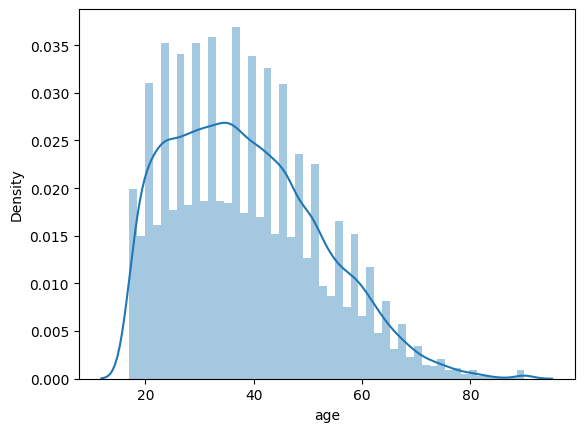

In [55]:
sns.distplot(data.age)

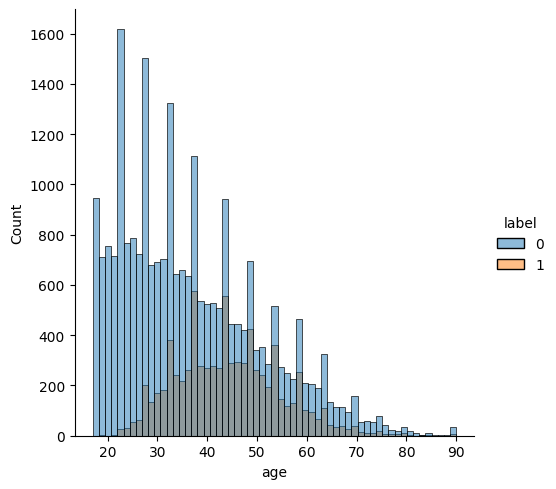

In [60]:
sns.displot(x = data.age,hue=data.label)

## Workclass

In [115]:
data.workclass.value_counts()

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
other                1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

<Axes: xlabel='workclass', ylabel='count'>

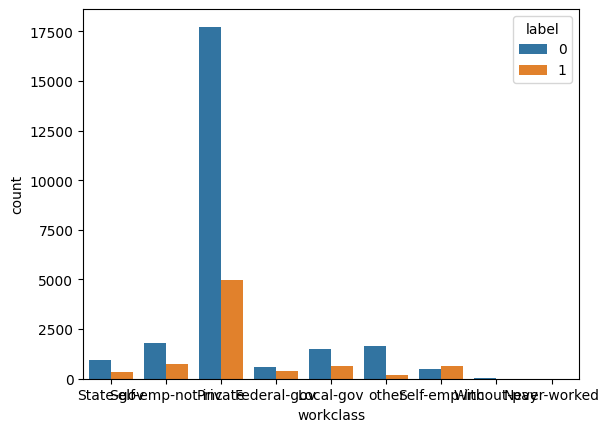

In [61]:
sns.countplot(x = data.workclass,hue=data.label)

In [124]:
data.groupby(['workclass'])['label'].mean()*100

workclass
Federal-gov         38.645833
Local-gov           29.479216
Never-worked         0.000000
Private             21.867289
Self-emp-inc        55.734767
Self-emp-not-inc    28.492719
State-gov           27.195686
Without-pay          0.000000
other               10.403050
Name: label, dtype: float64

In [126]:
data.groupby(['workclass','label'])['label'].count()

workclass         label
Federal-gov       0          589
                  1          371
Local-gov         0         1476
                  1          617
Never-worked      0            7
Private           0        17733
                  1         4963
Self-emp-inc      0          494
                  1          622
Self-emp-not-inc  0         1817
                  1          724
State-gov         0          945
                  1          353
Without-pay       0           14
other             0         1645
                  1          191
Name: label, dtype: int64

## education-num

<Axes: xlabel='education-num', ylabel='count'>

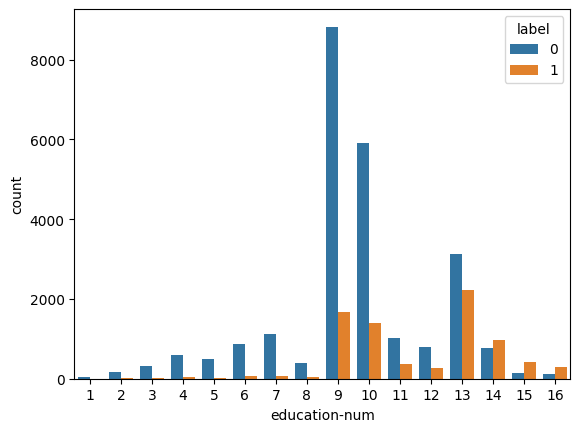

In [62]:
sns.countplot(x = data['education-num'],hue = data.label)

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\3998699211.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['education-num'])


<Axes: xlabel='education-num', ylabel='Density'>

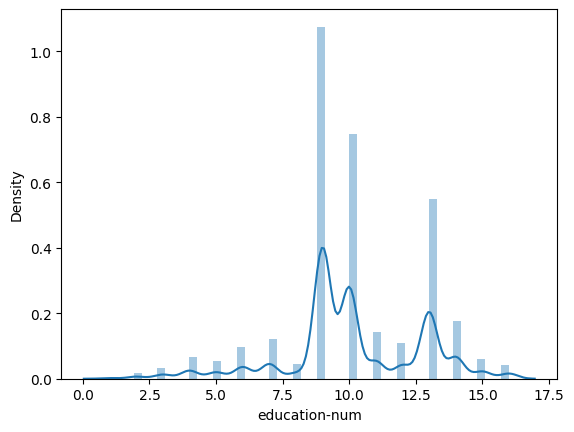

In [42]:
sns.distplot(data['education-num'])

## marital-status

<Axes: xlabel='marital-status', ylabel='count'>

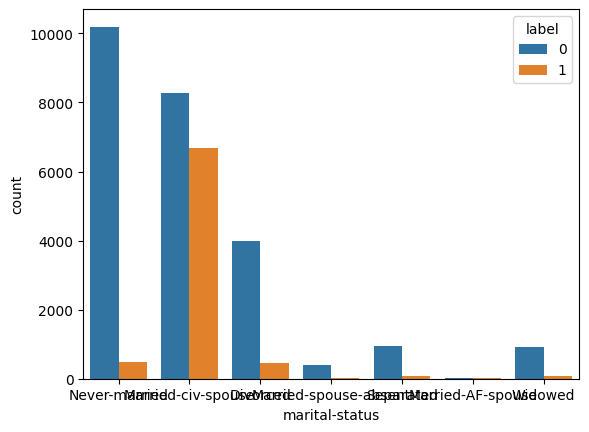

In [63]:
sns.countplot(x = data['marital-status'],hue = data.label)

In [64]:
data.isnull().sum()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
label             0
dtype: int64

## occupation        

<Axes: xlabel='occupation', ylabel='count'>

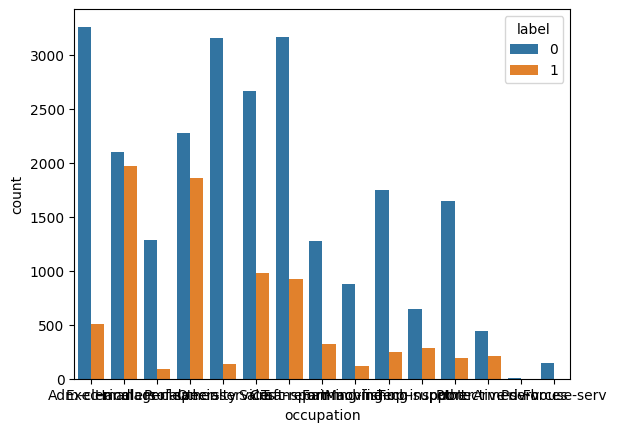

In [66]:
sns.countplot(x = data['occupation'],hue = data.label)

## relationship      

<Axes: xlabel='relationship', ylabel='count'>

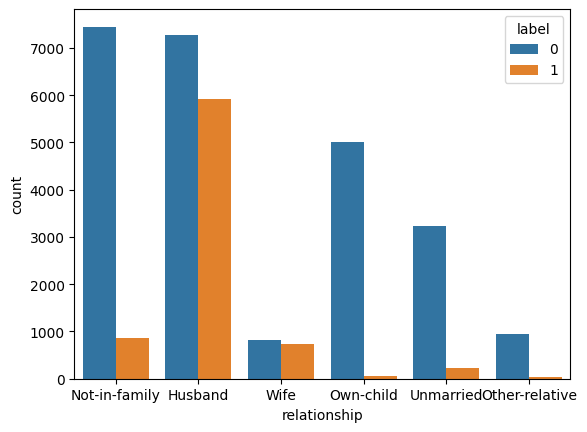

In [67]:
sns.countplot(x = data['relationship'],hue = data.label)

## Race

<Axes: xlabel='race', ylabel='count'>

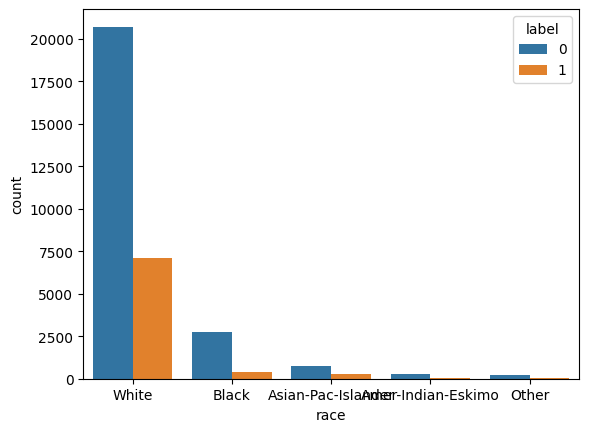

In [870]:
sns.countplot(x = data['race'],hue = data.label)

## sex               

<Axes: xlabel='sex', ylabel='count'>

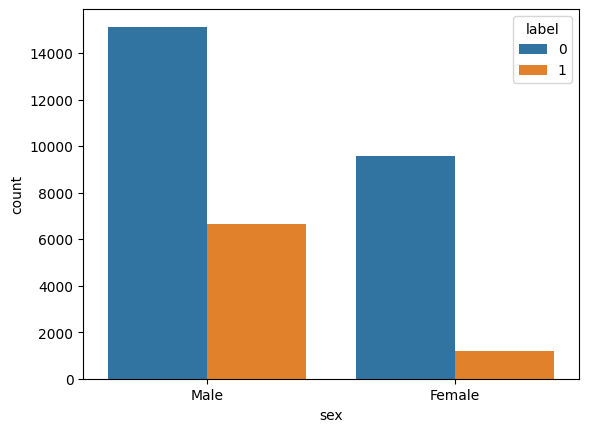

In [69]:
sns.countplot(x = data['sex'],hue = data.label)

In [70]:
data.isnull().sum()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
label             0
dtype: int64

## capital-gain & capital-loss

In [71]:
data.corr(numeric_only=True)[['capital-gain','capital-loss']]

,capital-gain,capital-loss
age,0.077674,0.057775
education-num,0.122630,0.079923
capital-gain,1.000000,-0.031615
capital-loss,-0.031615,1.000000
hours-per-week,0.078409,0.054256
label,0.223329,0.150526


In [72]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,label
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\3335155809.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['capital-gain'])


<Axes: xlabel='capital-gain', ylabel='Density'>

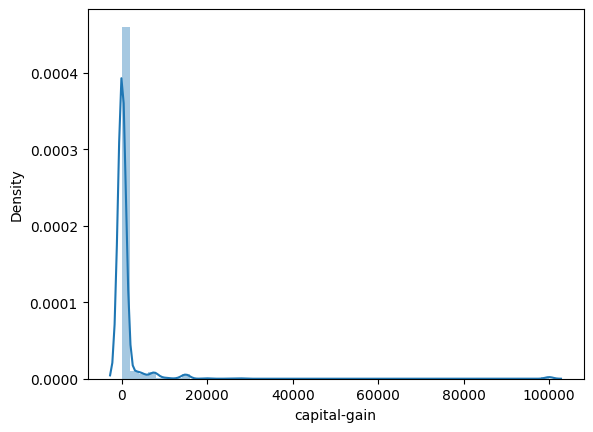

In [50]:
sns.distplot(data['capital-gain'])

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\2684858883.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['capital-loss'])


<Axes: xlabel='capital-loss', ylabel='Density'>

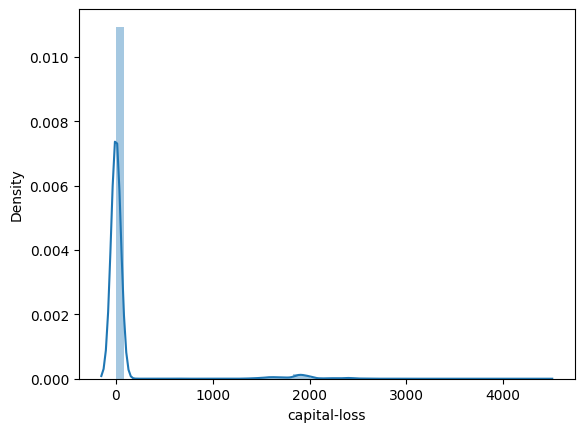

In [51]:
sns.distplot(data['capital-loss'])

## hours-per-week

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_8552\1173706245.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['hours-per-week'])


<Axes: xlabel='hours-per-week', ylabel='Density'>

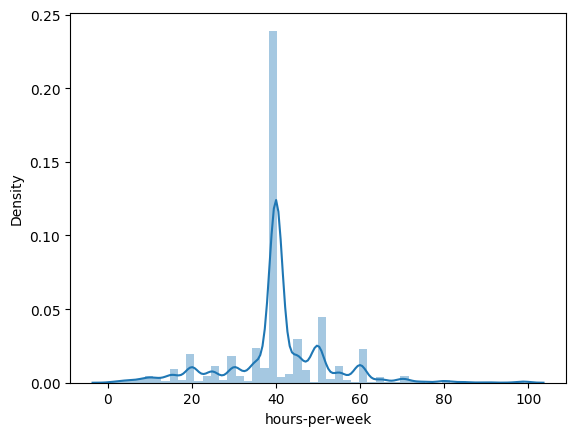

In [73]:
sns.distplot(data['hours-per-week'])

## Checking For Object Columns(Chi-Squre)

In [20]:
for i in data.columns:
    if data[i].dtype == 'object':
        print(i)
        contingency_table = pd.crosstab(data[i], data['label'])

        chi2, p, _, _ = chi2_contingency(contingency_table)

        print("Chi-squared statistic:", chi2)
        print("P-value:", p)

workclass
Chi-squared statistic: 1045.7085997281692
P-value: 2.0265054311207156e-220
education
Chi-squared statistic: 4429.653302288619
P-value: 0.0
marital-status
Chi-squared statistic: 6517.741653663022
P-value: 0.0
occupation
Chi-squared statistic: 4031.974280247181
P-value: 0.0
relationship
Chi-squared statistic: 6699.07689685885
P-value: 0.0
race
Chi-squared statistic: 330.9204310085741
P-value: 2.305960610160958e-70
sex
Chi-squared statistic: 1517.813409134445
P-value: 0.0
native-country
Chi-squared statistic: 317.2303857833171
P-value: 2.2113858852543023e-44


## Here Out P Value is very less then 0.05 so here we can conclude that every colimn has strong relation with our label column


In [74]:
data[data['hours-per-week'] == 1]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,label
189,58,State-gov,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,1,1
1036,66,Self-emp-inc,5,Married-civ-spouse,Exec-managerial,Husband,White,Male,1409,0,1,0
1262,69,other,11,Widowed,other,Not-in-family,White,Female,0,0,1,0
5590,78,other,9,Widowed,other,Not-in-family,White,Female,0,0,1,0
5632,45,other,14,Married-civ-spouse,other,Wife,White,Female,0,0,1,0
5766,62,other,10,Married-civ-spouse,other,Wife,White,Female,0,0,1,0
5808,76,other,6,Married-civ-spouse,other,Husband,White,Male,0,0,1,0
8447,67,other,11,Widowed,other,Not-in-family,White,Female,0,0,1,0
9147,75,other,6,Widowed,other,Other-relative,Asian-Pac-Islander,Female,0,0,1,0
11451,27,Private,9,Never-married,Machine-op-inspct,Other-relative,White,Male,0,0,1,0


In [14]:
new_data = data.copy()

In [236]:
Q1 = data['hours-per-week'].quantile(0.25)
Q3 = data['hours-per-week'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
data = data[(data['hours-per-week'] >= lower_bound) & (data['hours-per-week'] <= upper_bound)]

In [76]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,label
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [77]:
data.isnull().sum()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
label             0
dtype: int64

In [78]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,label
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


## Other Work

In [13]:
clean_house_per_hour_data = data

In [15]:
data = new_data.copy()

In [16]:
data.shape

(32561, 12)

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\4156840497.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.age)


<Axes: xlabel='age', ylabel='Density'>

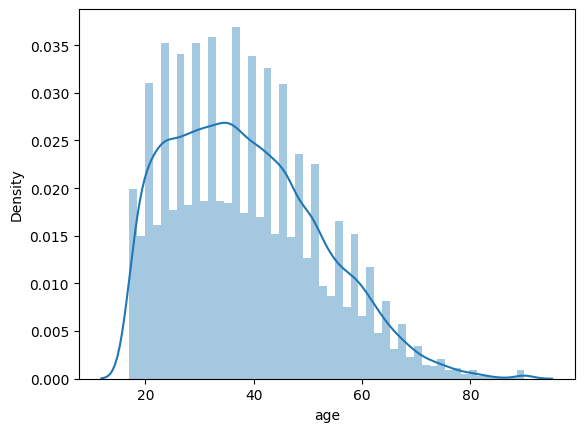

In [17]:
sns.distplot(data.age)

In [83]:
data[(data['age'] > 40) & (data['age'] <= 60)]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,label
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
6,49,Private,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,0
7,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,1
9,42,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32550,43,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,0
32552,43,Private,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,0
32554,53,Private,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,1
32558,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,0


In [334]:
def fun_age(x):
    if x <= 20:
        return 0
    elif x > 20 and x <= 40:
        return 1
    elif x > 40 and x <= 60:
        return 2
    else:
        return 3

In [335]:
#data['age'] = data['age'].apply(fun_age)
#data['hours-per-week'] = data['hours-per-week'].apply(fun_age)

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_7952\1173706245.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['hours-per-week'])


<Axes: xlabel='hours-per-week', ylabel='Density'>

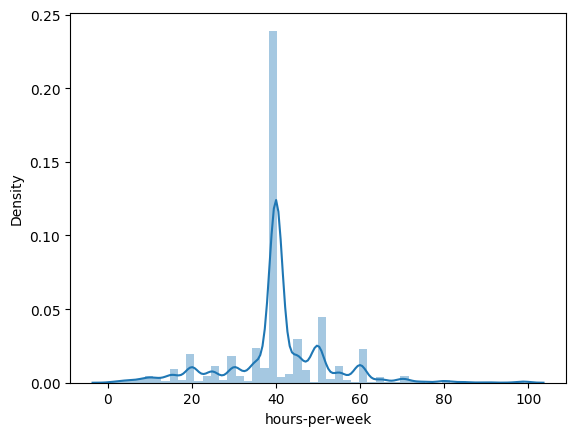

In [293]:
sns.distplot(data['hours-per-week'])

In [ ]:
(data['hours-per-week'] > 40) & (data['hours-per-week'] <= 60)

In [313]:
data[data['hours-per-week'] > 60]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,label
10,1,Private,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,1
28,1,Private,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,80,0
72,1,Self-emp-not-inc,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,70,1
179,1,Private,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,65,0
238,1,Local-gov,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,70,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32469,1,Self-emp-inc,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,99,0
32476,1,Private,8,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,84,0
32495,1,Private,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,65,0
32520,1,Private,9,Never-married,Other-service,Unmarried,White,Female,0,0,64,0


In [336]:
data['age'].value_counts()

age
1    16708
2    11111
0     2410
3     2332
Name: count, dtype: int64

In [202]:
data['hours-per-week'].value_counts()

hours-per-week
40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
82        1
92        1
87        1
74        1
94        1
Name: count, Length: 94, dtype: int64

In [415]:
def fun_capitel(x):
    if x != 0:
        return 1
    else:
        return x

In [769]:
data = new_data.copy()

In [440]:
#data['capital-gain'] = data['capital-gain'].apply(fun_capitel)
#data['capital-loss'] = data['capital-loss'].apply(fun_capitel)

In [770]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,label
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0


In [749]:
#data.drop(['marital-status','relationship','race'],axis=1,inplace=True)

### Function Transformation(age...)

In [243]:
trf = FunctionTransformer(func=np.log1p)

In [244]:
trf.fit_transform(data['age'])

0        3.688879
1        3.931826
2        3.663562
3        3.988984
4        3.367296
           ...   
32556    3.332205
32557    3.713572
32558    4.077537
32559    3.135494
32560    3.970292
Name: age, Length: 32561, dtype: float64

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\89720399.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trf.fit_transform(data['age']))


<Axes: xlabel='age', ylabel='Density'>

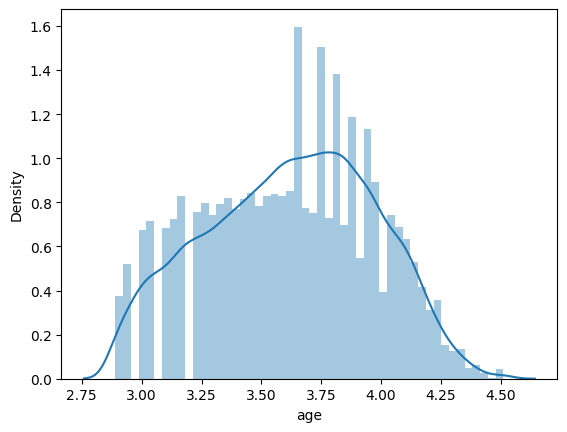

In [245]:
sns.distplot(trf.fit_transform(data['age']))

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\2151693420.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trf.fit_transform(data['hours-per-week']))


<Axes: xlabel='hours-per-week', ylabel='Density'>

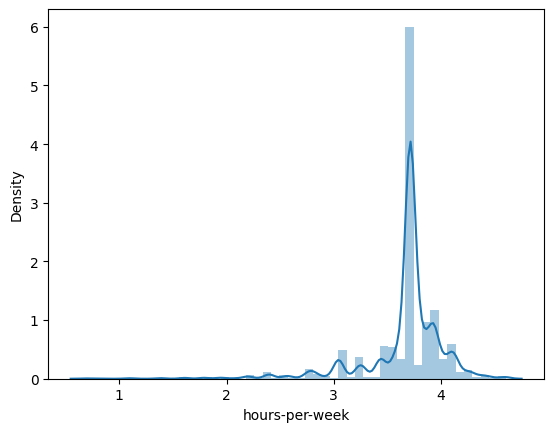

In [246]:
sns.distplot(trf.fit_transform(data['hours-per-week']))

C:\Users\DARSHIT\AppData\Local\Temp\ipykernel_12764\314126338.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trf.fit_transform(data['capital-gain']))


<Axes: xlabel='capital-gain', ylabel='Density'>

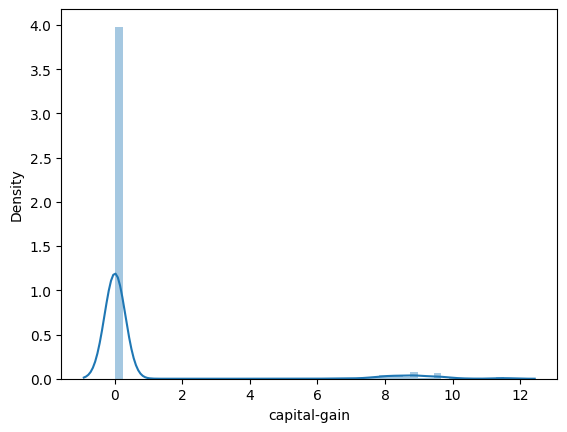

In [247]:
sns.distplot(trf.fit_transform(data['capital-gain']))

In [248]:
trf.fit_transform(data['age'])[0]

3.6888794541139363

In [268]:
trf.transform(data['capital-gain'])[0]

0.6931471805599453

### Binning

In [806]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,label
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0


In [827]:
data = new_data.copy()

In [828]:
data['age_bin'] = pd.cut(data['age'].astype(int), 3)
data['hpw_bin'] = pd.cut(data['age'].astype(int), 3)

## Model 

In [857]:
x = data.drop(['label'],axis=1)
y = data['label']

In [858]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=41)

In [859]:
x_train['capital-gain'].value_counts()

capital-gain
0        23857
15024      272
7688       236
7298       203
99999      128
         ...  
2538         1
1111         1
15020        1
1639         1
6097         1
Name: count, Length: 115, dtype: int64

In [860]:
x_train.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,age_bin,hpw_bin
21351,40,Self-emp-not-inc,11,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1977,15,"(16.927, 41.333]","(16.927, 41.333]"
22098,42,Federal-gov,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,"(41.333, 65.667]","(41.333, 65.667]"
15008,25,Private,2,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,96,"(16.927, 41.333]","(16.927, 41.333]"
32044,44,Private,2,Married-civ-spouse,Other-service,Wife,Asian-Pac-Islander,Female,0,0,40,"(41.333, 65.667]","(41.333, 65.667]"
49,29,Private,11,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,43,"(16.927, 41.333]","(16.927, 41.333]"


In [861]:
ct1 = ColumnTransformer([
    ('t1',OrdinalEncoder(),['education-num']),
    ('t2',FunctionTransformer(func=np.log1p),['age','hours-per-week','capital-gain','capital-loss']),
    ('t3',OneHotEncoder(sparse=False,drop='first',handle_unknown='ignore'),
     ['workclass','marital-status','occupation','relationship','race','sex','age_bin','hpw_bin'])
],remainder='passthrough')

In [862]:
ct1.fit_transform(x_train).shape

C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(26048, 47)

In [863]:
pipe = Pipeline([
    ('p1',ct1),
    ('scaler',StandardScaler()),
    ('model',gb)
])

In [864]:
pipe.fit(x_train,y_train)

C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('p1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('t1', OrdinalEncoder(),
                                                  ['education-num']),
                                                 ('t2',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['age', 'capital-gain',
                                                   'capital-loss']),
                                                 ('t4',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex', 'age_bin',
                                                   'hpw_bin'])])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier())])

In [865]:
y_pred = pipe.predict(x_test)

In [866]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [867]:
accuracy_score(y_test,y_pred)

0.8697988638108398

In [868]:
confusion_matrix(y_test,y_pred)

array([[4698,  237],
       [ 611,  967]], dtype=int64)

In [869]:
precision_score(y_test,y_pred)

0.803156146179402

In [789]:
np.mean(cross_val_score(pipe,x_train,y_train,cv=5,scoring='accuracy'))

C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

0.8647879924344732

## Voating Classifire

In [27]:
lg = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()

In [28]:
estimators = [('lr',lg),('rf',rf),('acv',svc)]
estimators_2 = [('rf1',rf),('rf2',rf),('rf3',rf)]

In [29]:
vc = VotingClassifier(estimators=estimators_2)

## Ada Boost

In [30]:
abc_lg = AdaBoostClassifier(base_estimator=lg, n_estimators=50) 
abc_rf = AdaBoostClassifier(base_estimator=rf, n_estimators=50)
abc_svc = AdaBoostClassifier(base_estimator=svc, n_estimators=50)

## Bagging

In [31]:
bag = BaggingClassifier(
    estimator=RandomForestClassifier(),
    random_state=42,
)

## Gradient Boosting

In [32]:
gb =GradientBoostingClassifier()

### GrideSearchCV

In [512]:
pd = {
    'learning_rate':[0.1,0.01,0.001],
    'n_estimators':[100,200,300,500,700,1000],
    'max_depth':[range(1,10),None],
}

In [513]:
gv = GridSearchCV(gb,param_grid=pd,cv=10,n_jobs=-1)

In [ ]:
x_train = ct1.fit_transform(x_train)
x_test = ct1.transform(x_test)

sc = StandardScaler()
x_train = sc.fit_transform(x_tra
x_test = sc.transform(x_test)

gv.fit(x_train,y_train)

pred_gv = gv.predict(x_test)

accuracy_score(y_test,pred_gv)

C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
gv.best_params_

In [ ]:
## What to apply
1) Log on age
2) removing ? values
3) making bins on age and hours

## Stacking

In [489]:
estimators = [
    ('rf', LogisticRegression()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svc',SVC())
]

In [490]:
stacking = StackingClassifier(
    estimators=estimators, 
    final_estimator=RandomForestClassifier(),
)

## XGBoost

In [501]:
xgb = XGBClassifier()

## Deep Learning

In [676]:
x_train = ct1.fit_transform(x_train)
x_test = ct1.transform(x_test)

C:\Users\DARSHIT\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [677]:
x_test

array([[9.        , 2.99573227, 3.04452244, ..., 0.        , 0.        ,
        0.        ],
       [8.        , 3.76120012, 3.71357207, ..., 0.        , 1.        ,
        0.        ],
       [9.        , 3.8501476 , 3.93182563, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [9.        , 2.99573227, 3.58351894, ..., 0.        , 0.        ,
        0.        ],
       [9.        , 3.76120012, 3.71357207, ..., 0.        , 1.        ,
        0.        ],
       [8.        , 3.36729583, 3.93182563, ..., 0.        , 0.        ,
        0.        ]])

In [678]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [679]:
model = Sequential()
model.add(Dense(512,input_dim = 44,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [680]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               23040     
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                

In [681]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [682]:
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
755/755 [==============================] - 6s 7ms/step - loss: 0.3512 - accuracy: 0.8345 - val_loss: 0.3363 - val_accuracy: 0.8425
Epoch 2/10
755/755 [==============================] - 5s 6ms/step - loss: 0.3362 - accuracy: 0.8446 - val_loss: 0.3320 - val_accuracy: 0.8462
Epoch 3/10
755/755 [==============================] - 5s 6ms/step - loss: 0.3316 - accuracy: 0.8445 - val_loss: 0.3307 - val_accuracy: 0.8503
Epoch 4/10
755/755 [==============================] - 5s 7ms/step - loss: 0.3282 - accuracy: 0.8461 - val_loss: 0.3416 - val_accuracy: 0.8412
Epoch 5/10
755/755 [==============================] - 5s 7ms/step - loss: 0.3265 - accuracy: 0.8472 - val_loss: 0.3308 - val_accuracy: 0.8507
Epoch 6/10
755/755 [==============================] - 5s 7ms/step - loss: 0.3235 - accuracy: 0.8489 - val_loss: 0.3374 - val_accuracy: 0.8515
Epoch 7/10
755/755 [==============================] - 5s 7ms/step - loss: 0.3215 - accuracy: 0.8501 - val_loss: 0.3303 - val_accuracy: 0.8520
Epoch 

In [692]:
y_pred = model.predict(x_test)

189/189 [==============================] - 0s 2ms/step


In [702]:
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)

In [703]:
y_pred_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [704]:
accuracy_score(y_test,y_pred_binary)

0.849494447207028

In [705]:
precision_score(y_test,y_pred_binary)

0.7134238310708899